In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pylab
import seaborn as sns

import datetime as dt

from scipy import stats

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit

import pandas_profiling

import itertools

In [260]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv.zip')
sales_train = pd.read_csv('sales_train.csv.zip',  parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32','item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
#sales_train = pd.read_csv('sales_train.csv.zip')
sample_submissions = pd.read_csv('sample_submission.csv.zip')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv.zip', index_col=0)

In [4]:
item_categories.head(3)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2

In [5]:
items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [6]:
sales_train.head(8)

date  date_block_num  shop_id  item_id   item_price  item_cnt_day
0 2013-02-01               0       59    22154   999.000000             1
1 2013-03-01               0       25     2552   899.000000             1
2 2013-05-01               0       25     2552   899.000000            -1
3 2013-06-01               0       25     2554  1709.050049             1
4 2013-01-15               0       25     2555  1099.000000             1
5 2013-10-01               0       25     2564   349.000000             1
6 2013-02-01               0       25     2565   549.000000             1
7 2013-04-01               0       25     2572   239.000000             1

In [7]:
sample_submissions.head(3)

ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5

In [8]:
shops.head(3)

shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1
2               Адыгея ТЦ "Мега"        2

In [261]:
test.head(3)

shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233

## Here we merge all tables related with the train data into one table

In [3]:
# merge data into one table
train = sales_train.join(items, on = 'item_id', rsuffix='_')\
                    .join(item_categories, on = 'item_category_id', rsuffix = '_')\
                    .join(shops, on = 'shop_id', rsuffix = '_')\
                    .drop(['item_id_', 'shop_id_', 'item_category_id_', 'item_name'], axis=1)

train['item_cnt_day'] = np.abs(train['item_cnt_day'])
train.head()

date  date_block_num  shop_id  item_id   item_price  item_cnt_day  \
0 2013-02-01               0       59    22154   999.000000             1   
1 2013-03-01               0       25     2552   899.000000             1   
2 2013-05-01               0       25     2552   899.000000             1   
3 2013-06-01               0       25     2554  1709.050049             1   
4 2013-01-15               0       25     2555  1099.000000             1   

   item_category_id                   item_category_name  \
0                37                       Кино - Blu-Ray   
1                58                       Музыка - Винил   
2                58                       Музыка - Винил   
3                58                       Музыка - Винил   
4                56  Музыка - CD фирменного производства   

                shop_name  
0  Ярославль ТЦ "Альтаир"  
1     Москва ТРК "Атриум"  
2     Москва ТРК "Атриум"  
3     Москва ТРК "Атриум"  
4     Москва ТРК "Атриум"

In [187]:
profile = pandas_profiling.ProfileReport(train)
profile

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [188]:
profset = profile.description_set          #Extracting the info from the profile object
print(profset.keys())

dict_keys(['analysis', 'table', 'variables', 'scatter', 'correlations', 'missing', 'messages', 'package', 'sample', 'duplicates'])


In [189]:
attributes = profset["variables"]
print(attributes.keys())

dict_keys(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id', 'item_category_name', 'shop_name'])


In [371]:
shop_attributes = attributes['shop_name']
shop_attributes_keys = shop_attributes.keys()
#shop_attributes_keys
#shop_attributes

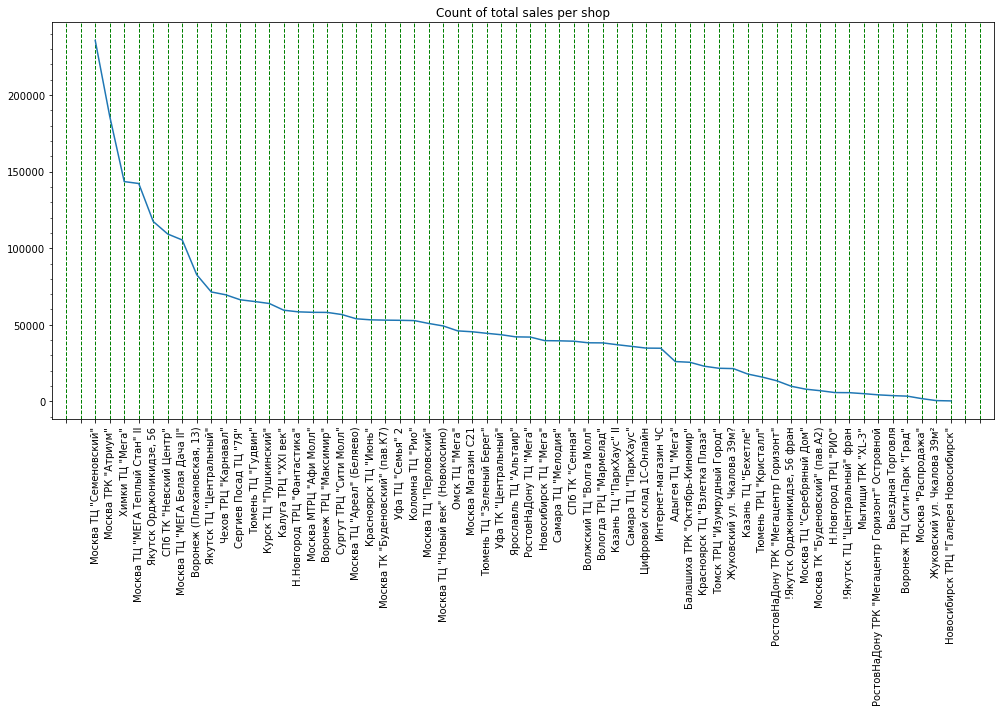

In [200]:
# this graphic is constructed for demonstration of possibility to exctract attributes from data with help of pandas profiling
fig, axes = plt.subplots(figsize=(14, 10))

axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

axes.yaxis.set_major_locator(ticker.MultipleLocator(50000))
axes.yaxis.set_minor_locator(ticker.MultipleLocator(10000))

np.arange(1, shop_attributes['value_counts'].count() + 1, 1)
axes.plot(shop_attributes['value_counts'])
axes.set_title('Count of total sales per shop')
axes.grid(axis = 'x', color = 'green', linewidth = 1, linestyle = '--')

plt.xticks(rotation=90)
 
plt.tight_layout()

## Split dates for more detailed exploration

In [11]:
train['date'] = pd.to_datetime(train['date'], format='%m.%Y')
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

train.head(4)

date  date_block_num  shop_id  item_id   item_price  item_cnt_day  \
0 2013-02-01               0       59    22154   999.000000             1   
1 2013-03-01               0       25     2552   899.000000             1   
2 2013-05-01               0       25     2552   899.000000             1   
3 2013-06-01               0       25     2554  1709.050049             1   

   item_category_id item_category_name               shop_name  day  month  \
0                37     Кино - Blu-Ray  Ярославль ТЦ "Альтаир"    1      2   
1                58     Музыка - Винил     Москва ТРК "Атриум"    1      3   
2                58     Музыка - Винил     Москва ТРК "Атриум"    1      5   
3                58     Музыка - Винил     Москва ТРК "Атриум"    1      6   

   year  
0  2013  
1  2013  
2  2013  
3  2013

## Check our data for missed values

In [19]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_category_id      0
item_category_name    0
shop_name             0
day                   0
month                 0
year                  0
dtype: int64

## Group data by date, shop, item and category 

In [4]:
# group data by month
train_grouped_by_month = train[["date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id"]]\
.groupby(['date_block_num',"shop_id", "item_id", "item_category_id"])\
.agg({"item_price":"mean","item_cnt_day":"sum"}).reset_index()
train_grouped_by_month.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

train_grouped_by_month.head(8)

date_block_num  shop_id  item_id  item_category_id  item_price  \
0               0        0       32                40       221.0   
1               0        0       33                37       347.0   
2               0        0       35                40       247.0   
3               0        0       43                40       221.0   
4               0        0       51                57       128.5   
5               0        0       61                43       195.0   
6               0        0       75                40        76.0   
7               0        0       88                40        76.0   

   item_cnt_month  
0               6  
1               3  
2               1  
3               1  
4               2  
5               1  
6               1  
7               1

## Sales count by shop_id and date graphic

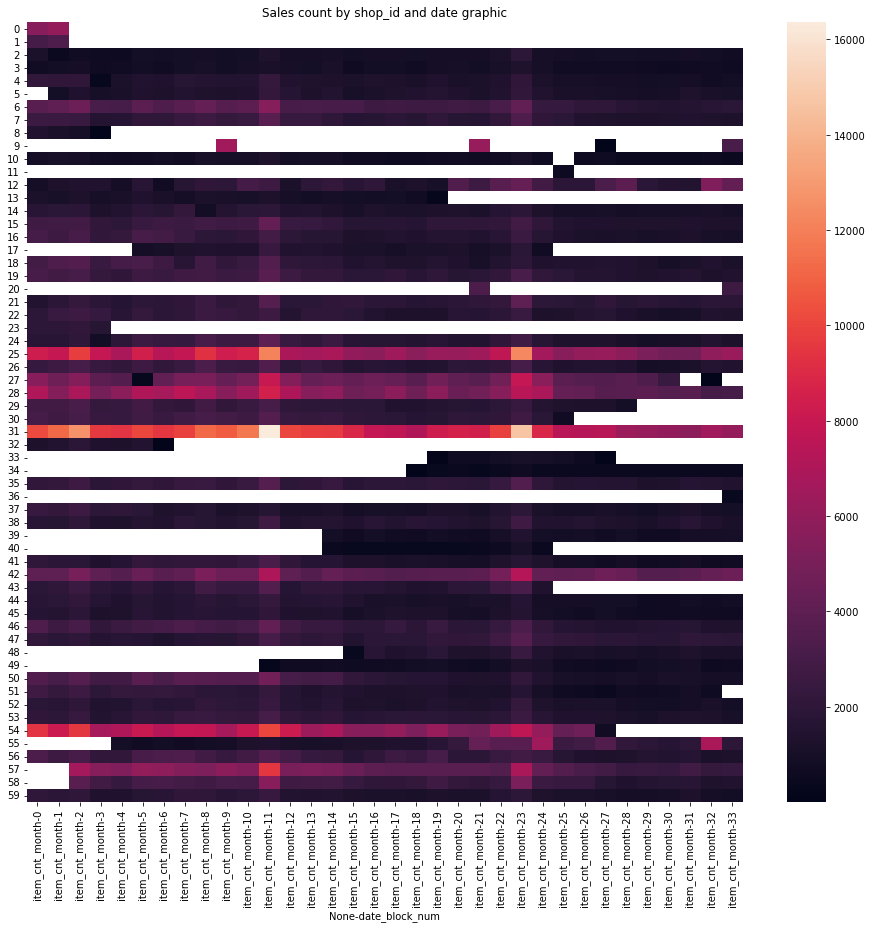

In [201]:
#sales_date_shop = train[['shop_id', 'date_block_num', 'item_cnt_day']].groupby(['date_block_num', 'shop_id'])\
#.agg({'item_cnt_day': sum})
sales_date_shop = train_grouped_by_month.pivot_table(index=['shop_id'], values=['item_cnt_month'],\
                                    columns='date_block_num', aggfunc=np.sum)
#.pivot_table(index=['shop_id'], values=['item_cnt_day'], 
#                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

#sales_date_shop.fillna(sales_date_shop.mean(), inplace=True)

fig = plt.figure(figsize=(13, 13)) 
ax = fig.add_subplot(111)
ax = sns.heatmap(sales_date_shop.reset_index(drop=True))
#plt.xlabel('Shops', fontsize = 15)
#plt.ylabel('Monthes', fontsize = 15)
ax.set_title('Sales count by shop_id and date graphic')
plt.tight_layout()

In [202]:
most_popular_items = train_grouped_by_month.groupby('item_id').agg({"item_cnt_month":"sum"}).reset_index()
most_popular_items = most_popular_items.sort_values(by='item_cnt_month', ascending=False)
most_popular_items = most_popular_items.iloc[0:10].reset_index()
#most_popular_items_indexes = most_popular_items['index']
most_popular_items
#most_popular_items_indexes

index  item_id  item_cnt_month
0  20602    20949          187678
1   2749     2808           17265
2   3654     3732           16710
3  17418    17717           15830
4   5717     5822           14529
5   3656     3734           11778
6   6543     6675           10341
7   3653     3731           10111
8   1814     1855           10050
9  16493    16787            9283

First item has the biggest total count of sales, so we can explorate this 

## Count histograms

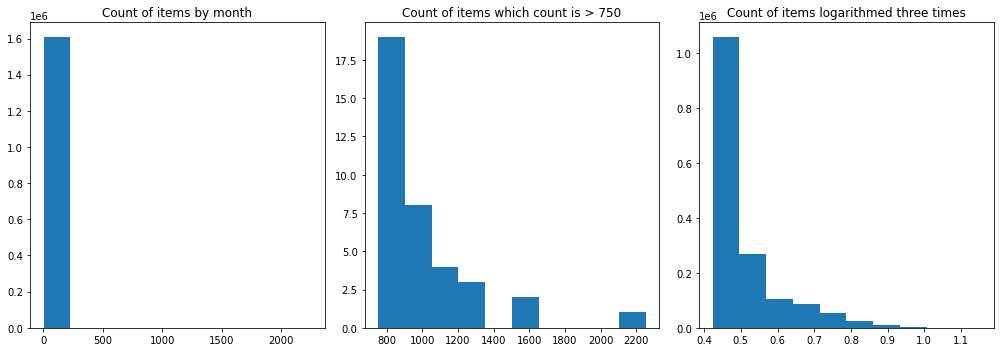

In [203]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

axes[0].hist(train_grouped_by_month['item_cnt_month'])
axes[0].set_title('Count of items by month')

axes[1].hist(train_grouped_by_month.query('item_cnt_month > 750')['item_cnt_month'])
axes[1].set_title('Count of items which count is > 750')

axes[2].hist(np.log(1 + np.log(1 + np.log(1 + train_grouped_by_month['item_cnt_month']))))
axes[2].set_title('Count of items logarithmed three times')

fig    
plt.tight_layout()

Here we can see that biggest part of count values belongs to [0,250], so we can explorate this interval separately

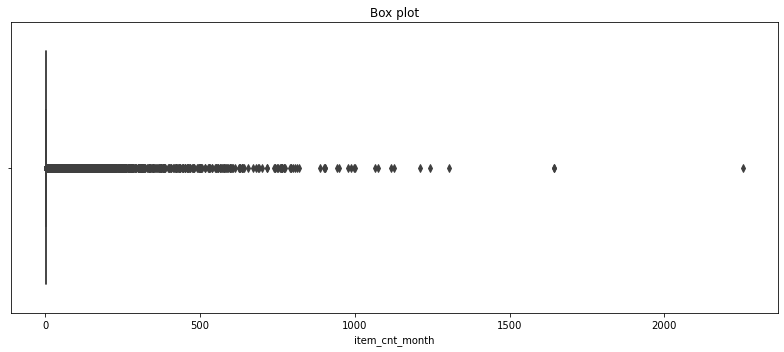

In [204]:
fig = plt.figure(figsize=(11, 5)) 
ax = fig.add_subplot(111)

sns.boxplot(x="item_cnt_month", data=train_grouped_by_month)
ax.set_title('Box plot')

plt.tight_layout()

We can see that almost all values are clipped into [0, 750], so we can explorate this interval, interval from 750 to 1300, and outliers, separately

## Price histograms

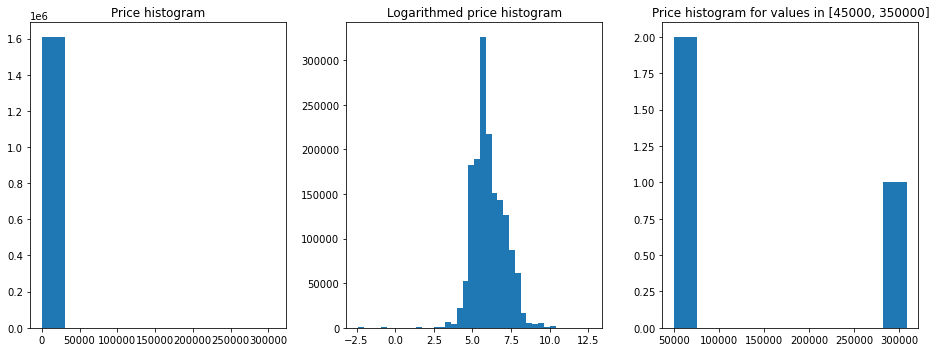

In [205]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

axes[0].hist(train_grouped_by_month['item_price'])
axes[0].set_title('Price histogram')

axes[1].hist(np.log(train_grouped_by_month['item_price']), bins=40)
axes[1].set_title('Logarithmed price histogram')

axes[2].hist(train_grouped_by_month.query('item_price > 45000 and item_price < 350000')['item_price'])
axes[2].set_title('Price histogram for values in [45000, 350000]')
fig    
plt.tight_layout()

From this graphics we can see that almost all values belongs to [0, 25000] and between 75000 and 275000 there are no values. So we can explorate separetely groups [0, 25000] and [275000, 300000]

((array([-4.92088874, -4.74440514, -4.64908479, ...,  4.64908479,
          4.74440514,  4.92088874]),
  array([-2.4079456, -2.4079456, -2.3644605, ..., 10.815409 , 10.839561 ,
         12.63779  ], dtype=float32)),
 (1.009043665803779, 6.071694374084473, 0.9781532892968127))

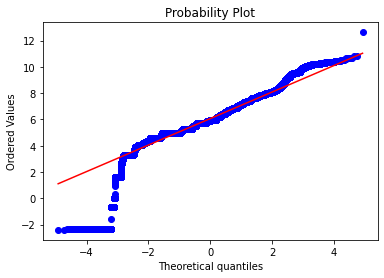

In [206]:
stats.probplot(np.log(train_grouped_by_month['item_price']), plot=plt)

We can see that logarithmed data are very similar to normal distribution from -2 to 2 standart deviations. Also we can see huge offset for quantiles less -2 s.d., so it's have sense to explorate this separetely

Text(0.5, 1.0, 'Sales count of price')

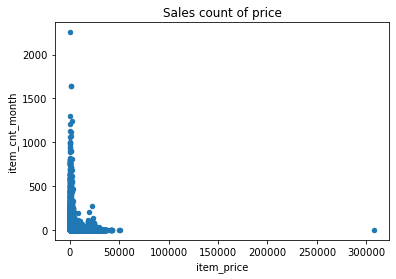

In [207]:
train_grouped_by_month.plot.scatter(x='item_price', y='item_cnt_month').set_title('Sales count of price')

<AxesSubplot:xlabel='item_price', ylabel='item_cnt_month'>

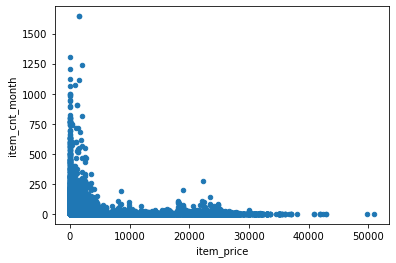

In [208]:
train_grouped_by_month.query('item_price < 300000 and item_cnt_month < 2000').plot.scatter(x='item_price', y='item_cnt_month')

Here we also see outliers for price values ~300000. Also we see that items with price [0,5000] have various sales counts (good idea is to split this group in some way). But price values >5000 have smaller various, except outliers. 

## Clip data into [0, 20]

In [5]:
train_grouped_by_month_clipped = train_grouped_by_month.copy()
train_grouped_by_month_clipped['logged_item_price'] = 2 + np.log(train_grouped_by_month_clipped['item_price'])
train_grouped_by_month_clipped['item_cnt_month'] = train_grouped_by_month['item_cnt_month'].clip(0., 20.)
train_grouped_by_month_clipped['item_cnt_month'].describe()

count    1.609124e+06
mean     2.031317e+00
std      2.581123e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

## Clipped count of sales

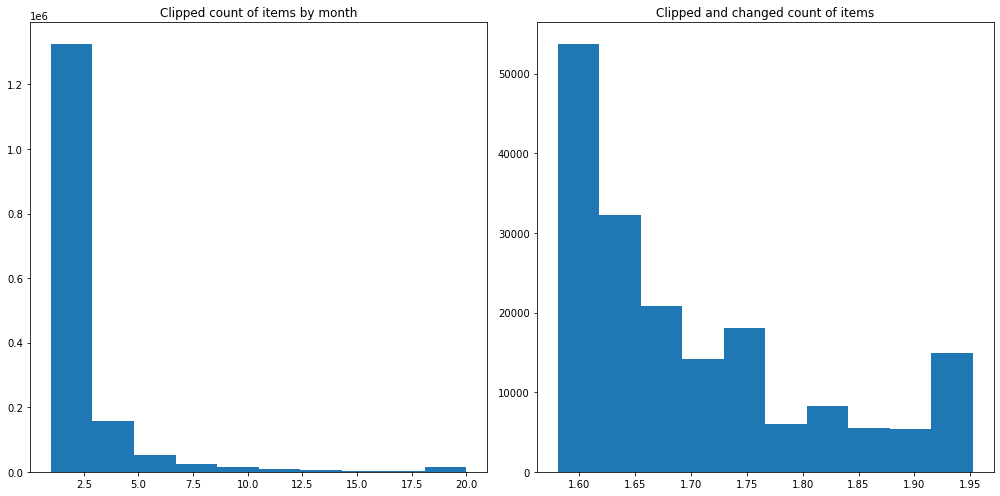

In [216]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

axes[0].hist(train_grouped_by_month_clipped['item_cnt_month'])
axes[0].set_title('Clipped count of items by month')

lmbda = 7.5
train_grouped_by_month_clipped['changed_item_cnt_month'] = \
                    np.exp(np.log(lmbda*train_grouped_by_month_clipped.query('item_cnt_month > 3')['item_cnt_month']+1)/lmbda)

axes[1].hist(train_grouped_by_month_clipped['changed_item_cnt_month'])
axes[1].set_title('Clipped and changed count of items')

fig    
plt.tight_layout()

We see that count of sales for value 20 is so big, because values more than 20 belongs to this after clipping. We can explorate group for values 20 separately

## Box-plot for clipped count of sales

Text(0.5, 1.0, 'Box plot for clipped count of sales')

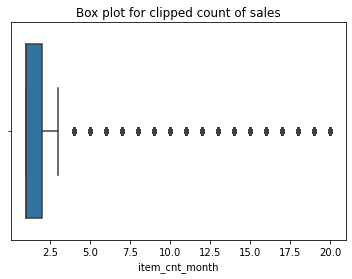

In [209]:
sns.boxplot(x="item_cnt_month", data=train_grouped_by_month_clipped).set_title('Box plot for clipped count of sales')

Text(0.5, 1.0, 'Box plot for clipped count of sales > 3')

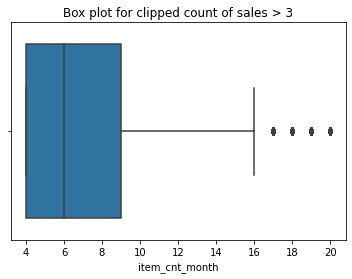

In [210]:
sns.boxplot(x="item_cnt_month", data=train_grouped_by_month_clipped.query('item_cnt_month > 3'))\
            .set_title('Box plot for clipped count of sales > 3')

We see that almost all values are in the [0, 3]. So we can explorate this values separetely

Text(0.5, 1.0, 'Clipped sales count of changed price')

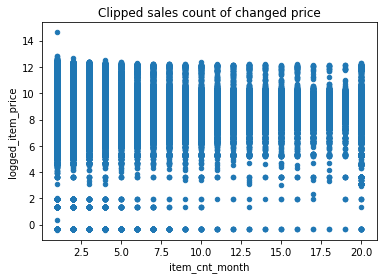

In [211]:
train_grouped_by_month_clipped.plot.scatter(x='item_cnt_month', y='logged_item_price')\
                            .set_title('Clipped sales count of changed price')

Lowest quantile is increasing except 20

## Outdated shops

In [36]:
sales_by_shop_id = sales_train.pivot_table(index=['shop_id'], values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

outdated_shops_by_date = [sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1) == 0].unique() \
                          for i in range(34)]

# for i in range(34):
#    print('Shop is outdated for month', i, \
#          sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1) == 0].unique())

Text(0.5, 1.0, 'Count of outdated shops by date')

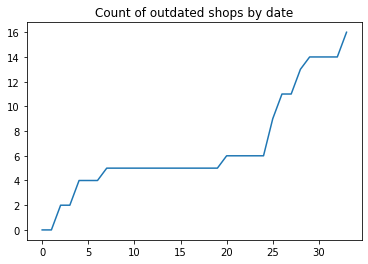

In [212]:
outdated_shops_count_by_date = pd.Series({i: len(outdated_shops_by_date[i]) for i in range(34)})
outdated_shops_count_by_date.plot().set_title('Count of outdated shops by date')

Shops with id 0, 1, 8, 11, 13, 17, 23, 29, 30, 32, 33, 40, 43, 54 are closed. So we can keep them into array and predict for them zeros.

## Outdated items

In [38]:
sales_by_item_id = sales_train.pivot_table(index=['item_id'], values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'shop_id'

outdated_items_by_date = \
        {i: sales_by_item_id['shop_id'][sales_by_item_id.loc[:,str(i):].sum(axis=1) == 0].unique() for i in range(34)}


#for i in range(34):
#print('Item is outdated for month', i, outdated_items_by_date[i])

There are many outdated items, so we can write algorithm, which takes items that are outdated for 3 (for example) last monthes and predict for them zero, independetly on it's shop_id

Text(0.5, 1.0, 'Count of outdated items by date')

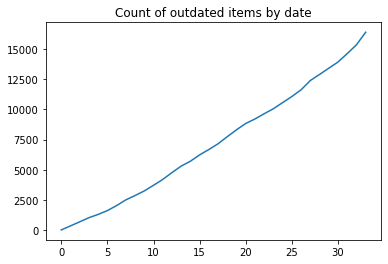

In [214]:
outdated_items_count_by_date = pd.Series({i: len(outdated_items_by_date[i]) for i in range(34)})
outdated_items_count_by_date.plot().set_title('Count of outdated items by date')

## Function for obtaining regression line for Series

In [40]:
def get_regression_line(data: pd.Series) -> pd.Series:
    size = data.size
    x = pd.Series(range(size))
    
    mean_x = x.mean()
    sigma_x = x.std()
    
    mean_y = data.mean()
    sigma_y = data.std()
    
    corr_coef = np.corrcoef(x, data)[0][1]
    
    regression_line = pd.Series(mean_y + corr_coef * sigma_y / sigma_x * (x - mean_x))
    
    return regression_line

## From this graphic we can obtain that sales have huge values on december

Text(0.5, 1.0, 'Count of sales by date')

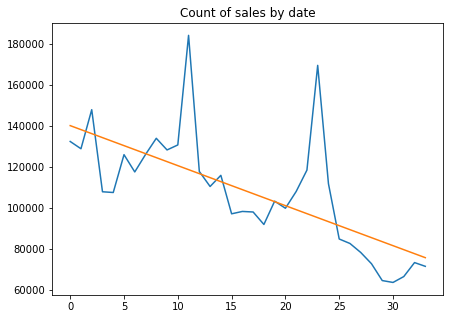

In [215]:
sales_by_date = train_grouped_by_month.groupby(['date_block_num'])['item_cnt_month'].sum()
regression_line_count = get_regression_line(sales_by_date)

fig = plt.figure(figsize=(7,5)) 
ax = fig.add_subplot(111)
ax.plot(pd.Series(range(34)), sales_by_date, pd.Series(range(34)), regression_line_count)
ax.set_title('Count of sales by date')

We can see that sales are decreasing, so it have sense to delete trend here. 

## Here we delete trend for count of sales

Text(0.5, 1.0, 'Count of sales without trend')

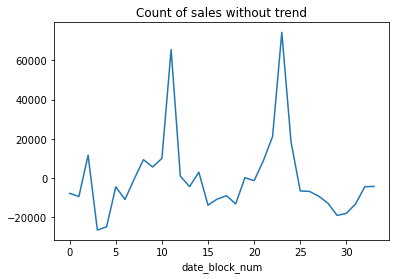

In [217]:
sales_without_trend = sales_by_date - regression_line_count
sales_without_trend.plot().set_title('Count of sales without trend')

We can notice cycles at this graphic, so it's have sense to group data by monthes and delete seasonality

## Average sales count per month

Text(0.5, 1.0, 'Mean count of sales without trend by month')

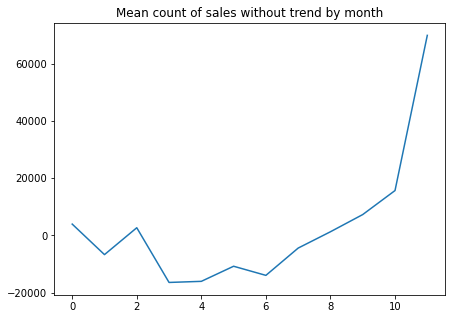

In [218]:
sales_count_by_month = np.zeros(12)

# Aggregate all count sales
sales_without_trend = sales_without_trend.to_numpy()
sales_count_by_month += (sales_without_trend[:12] + sales_without_trend[12:24])
# Last 3 monthes are not in our date period
sales_count_by_month += np.concatenate([sales_without_trend[24:33], np.zeros(3)])
    
# Some monthes occurs 3 times, another - 2 times
count_of_monthes = np.concatenate([np.full(9, 3), np.full(3, 2)])
sales_count_by_month /= count_of_monthes
    
fig = plt.figure(figsize=(7, 5)) 
ax = fig.add_subplot(111)
ax.plot(np.arange(0, 12, 1), sales_count_by_month)
ax.set_title('Mean count of sales without trend by month')

We see huge sales by decembers, increasing sales count from 6 month to 11, stagnation from 3 month to 6 and the standart sales from 0 to 2 month

## Total price by date

Text(0.5, 1.0, 'Total price for date')

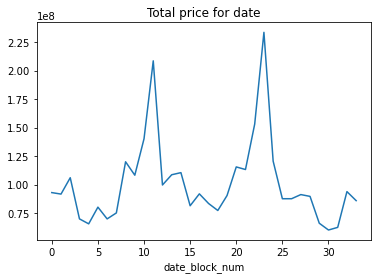

In [219]:
train_grouped_by_month['total_price'] = train_grouped_by_month['item_price'] * train_grouped_by_month['item_cnt_month']
sales_price_by_date = train_grouped_by_month.groupby(['date_block_num'])['total_price'].sum()
sales_price_by_date.plot().set_title('Total price for date')

## Mean total price per monthes

We can see here cycles, so we need to group data by monthes

Text(0.5, 1.0, 'Mean count of sales without trend by month')

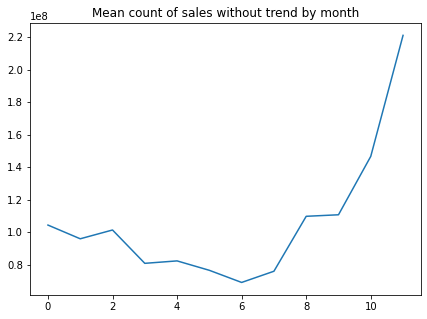

In [220]:
sales_price_by_month = np.zeros(12)

# Aggregate all count sales
sales_price_by_date = sales_price_by_date.to_numpy()
sales_price_by_month += (sales_price_by_date[:12] + sales_price_by_date[12:24])
# Last 3 monthes are not in our date period
sales_price_by_month += np.concatenate([sales_price_by_date[24:33], np.zeros(3)])
    
# Some monthes occurs 3 times, another - 2 times
count_of_monthes = np.concatenate([np.full(9, 3), np.full(3, 2)])
sales_price_by_month /= count_of_monthes
    
fig = plt.figure(figsize=(7, 5)) 
ax = fig.add_subplot(111)
ax.plot(np.arange(0, 12, 1), sales_price_by_month)
ax.set_title('Mean count of sales without trend by month')

This graphic is very similar to the same count graphic

## Number of items per category

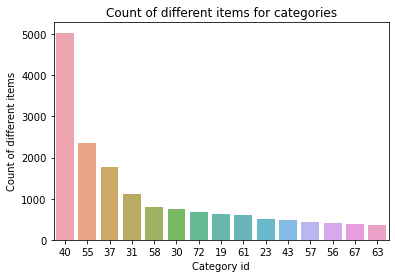

In [221]:
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id', ascending=False)
x=x.iloc[0:15].reset_index()
x['item_category_id'] = x['item_category_id'].astype(str)
#x=x.reset_index()

ax= sns.barplot(x=x.item_category_id, y=x.item_id, alpha=0.85)

ax.set_title('Count of different items for categories')
ax.set_xlabel('Category id')
ax.set_ylabel('Count of different items')

plt.show()

We see that category №40 has more different items, so we can split it into bins in future

## Obviously sales are decreaing

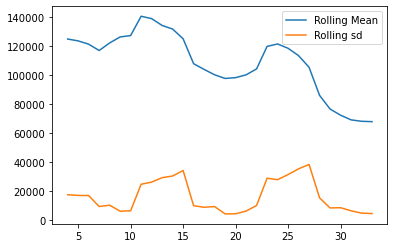

In [222]:
# rolling mean and standart deviation
plt.plot(sales_by_date.rolling(window=5,center=False).mean(),label='Rolling Mean');
plt.plot(sales_by_date.rolling(window=5,center=False).std(),label='Rolling sd');
plt.legend();

We see that rolling mean and standart deviation are also increased for decembers

## Shops that cells certain items from test and train

In [861]:
common_part = pd.merge(test, train_grouped_by_month_clipped, how='inner', on=['shop_id', 'item_id'])
common_part = common_part[['shop_id', 'item_id']].drop_duplicates()
common_part

shop_id  item_id
0             5     5037
9             5     5233
14            5     5232
15            5     5039
21            5     5041
...         ...      ...
600135       45     4352
600142       45    18049
600145       45    18454
600150       45    15757
600156       45      969

[111404 rows x 2 columns]

## Shops that cells certain items from test and them are not in train

In [864]:
difference = test.merge(common_part, how = 'outer' ,indicator=True).loc[lambda x : x['_merge'] == 'left_only']
difference = difference[['shop_id', 'item_id']]
difference

shop_id  item_id
1             5     5320
4             5     5268
9             5     5003
16            5     4874
21            5     5002
...         ...      ...
214188       45     9500
214189       45    16007
214194       45    18027
214196       45    16188
214198       45    19648

[102796 rows x 2 columns]

## How long items from test are outdated

In [877]:
item_ids = test[['item_id']].sort_values(by='item_id', ascending = True).drop_duplicates()
item_ids = np.array(item_ids).reshape(-1)
item_ids

array([   30,    31,    32, ..., 22164, 22166, 22167], dtype=int64)

In [884]:
date_blocks = np.zeros(34)
non_sales_count = 0

for item_id in item_ids:
    outdated_month = train_grouped_by_month_clipped.query('item_id == {0}'.format(item_id))['date_block_num'].max()
    #print(outdated_month)
    if np.isnan(outdated_month):
        non_sales_count += 1
    else:
        date_blocks[outdated_month] += 1
    
date_blocks

array([0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 6.000e+00, 2.000e+00,
       3.000e+00, 1.000e+00, 4.000e+00, 7.000e+00, 5.000e+00, 1.300e+01,
       1.200e+01, 9.000e+00, 1.500e+01, 4.000e+00, 8.000e+00, 1.400e+01,
       1.200e+01, 1.500e+01, 2.700e+01, 2.200e+01, 4.200e+01, 5.000e+01,
       7.700e+01, 1.100e+02, 2.810e+02, 3.991e+03])

<AxesSubplot:>

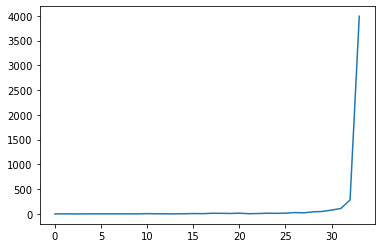

In [888]:
pd.Series(date_blocks).plot()

In [885]:
non_sales_count

363

<AxesSubplot:xlabel='shop_id', ylabel='Density'>

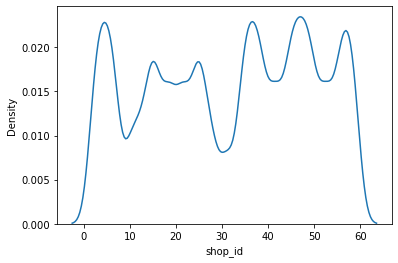

In [855]:
sns.kdeplot(test['shop_id'])

In [889]:
train_grouped_by_month_clipped

date_block_num  shop_id  item_id  item_category_id  item_price  \
0                     0        0       32                40       221.0   
1                     0        0       33                37       347.0   
2                     0        0       35                40       247.0   
3                     0        0       43                40       221.0   
4                     0        0       51                57       128.5   
...                 ...      ...      ...               ...         ...   
1609119              33       59    22087                83       119.0   
1609120              33       59    22088                83       119.0   
1609121              33       59    22091                83       179.0   
1609122              33       59    22100                42       629.0   
1609123              33       59    22102                42      1250.0   

         item_cnt_month  logged_item_price  
0                     6           7.398163  
1                     3           7.849325  
2                     1           7.509388  
3                     1           7.398163  
4                     2           6.855929  
...                 ...                ...  
1609119               6           6.779123  
1609120               2           6.779123  
1609121               1           7.187386  
1609122               1           8.444132  
1609123               1           9.130899  

[1609124 rows x 7 columns]

In [787]:
X = pd.concat([train_grouped_by_month_clipped, test], ignore_index = True)
shop_id_arr = np.array(X[['shop_id']].drop_duplicates().sort_values(by='shop_id', ascending = True)).reshape(-1)
shop_id_arr
# we can see that there 60 shop id's

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

In [788]:
shop_ids = []
item_ids = []
date_block_nums = []

for shop_id in range(0, 60):
    current_shop = X[X['shop_id'] == shop_id][['item_id']].drop_duplicates().sort_values(by='item_id', ascending = True)
    current_shop = np.array(current_shop).reshape(-1)
    count_of_items = len(current_shop)
    
    for item_id in current_shop: 
        item_ids.extend([item_id for i in range(34)])
        date_block_nums.extend(range(34))

    shop_ids.extend([shop_id for i in range(count_of_items * 34)])
    
formated_table = pd.DataFrame({'shop_id': shop_ids, 'item_id': item_ids, 'date_block_num': date_block_nums})
formated_table

shop_id  item_id  date_block_num
0               0       30               0
1               0       30               1
2               0       30               2
3               0       30               3
4               0       30               4
...           ...      ...             ...
17915275       59    22167              29
17915276       59    22167              30
17915277       59    22167              31
17915278       59    22167              32
17915279       59    22167              33

[17915280 rows x 3 columns]

In [890]:
X_train = pd.merge(formated_table, train_grouped_by_month_clipped, on=['shop_id', 'item_id', 'date_block_num'], how='left')
X_train = X_train[['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price']].fillna(0)
X_train.sample(7)

shop_id  item_id  date_block_num  item_cnt_month  item_price
949453          4    12516               3             0.0         0.0
7492080        27     5146              10             1.0      1749.0
5936073        22    16787              13             2.0      2599.0
4502035        18     3181              27             0.0         0.0
14922134       52     1944              10             0.0         0.0
9429911        32     9493              11             0.0         0.0
14607212       51     1103              30             0.0         0.0

In [820]:
y_train = X_train['item_cnt_month']

In [817]:
X_train

shop_id  item_id  date_block_num  item_cnt_month
0               0       30               0             0.0
1               0       30               1            20.0
2               0       30               2             0.0
3               0       30               3             0.0
4               0       30               4             0.0
...           ...      ...             ...             ...
17915275       59    22167              29             0.0
17915276       59    22167              30             0.0
17915277       59    22167              31             0.0
17915278       59    22167              32             0.0
17915279       59    22167              33             0.0

[17915280 rows x 4 columns]

## Class which adds features to data

In [891]:
class FeatureEngineeringSimple:
    def __init__(self):
        pass
    
    
    def add_lag_count(self, X, monthes_nums):
        last_month = X['date_block_num'].max()
        
        result_df = X.query('date_block_num == {0}'.format(last_month))[['shop_id', 'item_id']]
        
        for month_num in monthes_nums:
            X_lag = None
            if last_month >= month_num:
                X_lag = X[X['date_block_num'] == last_month - month_num][['shop_id', 'item_id', 'item_cnt_month']]
                X_lag = X_lag.rename({'item_cnt_month': 'lag_{0}'.format(month_num)}, axis = 1)
                X_lag = X_lag.groupby(['shop_id', 'item_id']).agg('sum')
            else:
                X_lag = X.query('date_block_num == {0}'.format(last_month))[['shop_id', 'item_id']]
                X_lag['lag_{0}'.format(month_num)] = 0

            result_df = pd.merge(result_df, X_lag, on=['shop_id', 'item_id'], how='left')
           
        result_df['date_block_num'] = last_month
        
        return result_df
    
    
    def add_item_mean_price(self, X):
        pass
    
    
    # adds mean, min and max statistics
    def add_item_cnt_stats(self, X):
        pass
    
    
    def add_shop_mean(self, X):
        pass
    
    
    def add_item_mean(self, X):
        pass
    
    
    def fit_transform(self, X, monthes_nums = [1, 2, 3, 6, 12]):
        lag_features = self.add_lag_count(X, monthes_nums)
        # select any month just to predict in appropriate format
        X = X.query('date_block_num == {0}'.format(X['date_block_num'].max()))[['shop_id', 'item_id']]
        X = pd.merge(X, lag_features, on=['shop_id', 'item_id'], how='left').drop(['date_block_num'], axis = 1)
        X = X.fillna(0)
        
        return X
    
    
    def transform_all_data(self, X, monthes_nums = [1, 2, 3, 6, 12]):
        first_month = X['date_block_num'].min()
        last_month = X['date_block_num'].max()
        
        result_df = None
        
        for month in range(first_month, last_month + 1):
            X_tmp = self.add_lag_count(X.query('date_block_num <= {0}'.format(month)), monthes_nums)
            result_df = pd.concat([result_df, X_tmp], ignore_index = True)
            
        return result_df

In [815]:
X_train_val = FeatureEngineeringSimple().transform_all_data(X_train)

In [823]:
X_train_val['item_cnt_month'] = y_train
X_train_val.sample(5)

shop_id  item_id  lag_1  lag_2  lag_3  lag_6  lag_12  \
3218109         7     2908    0.0    0.0    0.0    0.0     0.0   
7963673         7     9910    0.0    1.0    0.0    0.0     0.0   
8819691        46    12409    0.0    0.0    0.0    0.0     0.0   
16694843       43    16890    0.0    0.0    0.0    0.0     0.0   
8982522         4     5737    0.0    0.0    0.0    0.0     0.0   

          date_block_num  item_cnt_month  
3218109                6             0.0  
7963673               15             0.0  
8819691               16             0.0  
16694843              31             0.0  
8982522               17             0.0

In [698]:
class MyEstimator():
    def __init__(self, params = {'n_estimators': 50, 'max_depth': 5, 'n_jobs': -1}):
        self.feature_engineering = FeatureEngineeringSimple()
        self.estimator = RandomForestClassifier(**params)
    
    
    def predict(self, X):
        X = self.feature_engineering.fit_transform(X)
        X = X.drop(['item_id'], axis = 1)
        X = self.estimator.predict(X)
        
        return X
    
    
    def fit(self, X, y = None):
        X_train = self.feature_engineering.fit_transform(X)
        X_train = X_train.drop(['item_id'], axis = 1)
        
        self.estimator.fit(X_train, y)
        
        return self

In [699]:
def get_weighted_scores(scores, w):
    arr_len = len(scores)

    assert w > 1

    weights = [w ** deg for deg in range(arr_len - 1)]
    # we need to give bigger weight to the "first" month
    weights.insert(0, w ** (arr_len - 1))

    weights /= np.sum(weights)

    weighted_scores = np.array(weights) * np.array(scores)

    return np.sum(weighted_scores)

In [840]:
class MyCrossValidation:
    def __init__(self, n_last_val_monthes: int = 12, w_func = get_weighted_scores, parametres = {}, 
                 estimator = MyEstimator, scoring = mean_squared_error):
        self.n_last_val_monthes = n_last_val_monthes
        self.w_func = w_func
        self.clf = estimator
        self.parametres = parametres
        self.best_params = None
        self.scoring = scoring
        self.params_combinations = None
        self.get_params_combinations()
        self.best_estimator = None
        self.folds_scores = {}
        self.last_month = None
        self.best_weighted_score = None
        
        
    # get list of parametres samples dictionaries 
    def get_params_combinations(self):
        result = []
            
        all_combinations = itertools.product(*self.parametres.values())
        keys = self.parametres.keys()
        
        for combination in all_combinations:
            temp_dict = {k: v for k, v in zip(keys, combination)}
            result.append(temp_dict)
        
        self.params_combinations = result
        
        
    # sequentially learns on train and obtains score for validation month; afterwards returns weighted score
    def calculate_model_weighted_score(self, parametres, X):
        scores = []
        estimator = self.clf(**parametres)
        
        parametres_str = str(parametres)
        self.folds_scores[parametres_str] = []
        split_counter = 1
        
        self.last_month = X['date_block_num'].max()
        first_month = self.last_month - self.n_last_val_monthes + 1
        
        for index in range(first_month, self.last_month + 1):
            train_data = X.query('date_block_num == {0}'.format(index - 1))
            X_train = train_data.drop(['item_cnt_month', 'shop_id', 'item_id'], axis = 1)
            y_train = train_data['item_cnt_month']
            estimator.fit(X_train, y_train)
            
            val_data = X.query('date_block_num == {0}'.format(index))
            X_val = val_data.drop(['item_cnt_month', 'shop_id', 'item_id'], axis = 1)
            y_val = val_data['item_cnt_month']
            
            y_pred = estimator.predict(X_val)
            score = self.scoring(y_pred, y_val) ** 0.5
            
            self.folds_scores[parametres_str].append( ('split {0}'.format(split_counter), score) )
            split_counter += 1
            
            scores.append(score)
        
        result_score = self.w_func(scores, 1.15)
        
        return result_score
    
    
    # going through all possible parametres combinations and selects the best with respect to the minimal weighted score
    def select_best_model(self, X):
        best_weighted_score = np.inf
        
        for parametres in self.params_combinations:
            weighted_score = self.calculate_model_weighted_score(parametres, X)
            
            if weighted_score < best_weighted_score:
                self.best_weighted_score = weighted_score
                self.best_params = parametres
        
        self.last_month = X['date_block_num'].max()
        
        self.best_estimator = self.clf(**self.best_params)
        data_final_train = X.query('date_block_num == {0}'.format(self.last_month))
        self.best_estimator.fit(data_final_train.drop(['item_cnt_month'], axis = 1), data_final_train['item_cnt_month'])
        
        return self
    
    
    def predict(self, X):
        y = self.best_estimator.predict(X)
        return y

In [829]:
mcv = MyCrossValidation(12, get_weighted_scores, {
                            'n_estimators': range(400, 401, 50), 
                            'max_depth': range(20, 21), 
                            'n_jobs': [-1]
                        }, RandomForestClassifier, mean_squared_error)

mcv.select_best_model(X_train_val)
mcv.best_weighted_score

1.017111837369891

In [707]:
y_pred = mcv.predict(X_train_val)

In [719]:
final_table = X_train.query('date_block_num == 33')
final_table['item_cnt_month'] = y_pred
test_copy = test.copy()
final_res = pd.merge(test_copy, final_table, on=['shop_id', 'item_id'], how='left')

C:\Users\YAUHEN~1\AppData\Local\Temp/ipykernel_4148/2455767538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table['item_cnt_month'] = y_pred


In [720]:
final_res = final_res[['item_cnt_month']]
final_res.to_csv('RES.csv', encoding='utf-8')

In [830]:
mcv.best_params

{'n_estimators': 400, 'max_depth': 20, 'n_jobs': -1}

In [831]:
mcv.folds_scores

{"{'n_estimators': 400, 'max_depth': 20, 'n_jobs': -1}": [('split 1',
   1.2526840537403705),
  ('split 2', 0.7677614230163772),
  ('split 3', 0.9120348047126335),
  ('split 4', 0.8595408341716184),
  ('split 5', 0.5930481779330669),
  ('split 6', 0.8942637952638044),
  ('split 7', 0.748343903996519),
  ('split 8', 1.2118504727727442),
  ('split 9', 1.2731944330596559),
  ('split 10', 1.0117262074164375),
  ('split 11', 1.1471648733468334),
  ('split 12', 0.8466378910225697)]}

In [837]:
class MyNestedCV:
    def __init__(self):
        self.scores = []
    
    
    def estimate_pipeline(self, X, val_params):
        self.scores = []
        
        monthes_count = val_params['n_last_nested_val_monthes']
        
        max_month = X['date_block_num'].max()
        
        for validation_num in range(monthes_count):
            current_last_month = max_month - validation_num
            
            X_train = X.query('date_block_num < {0}'.format(current_last_month))
            X_val = X.query('date_block_num == {0}'.format(current_last_month)).drop(['item_cnt_month'], axis = 1)
            y_val = X.query('date_block_num == {0}'.format(current_last_month))['item_cnt_month']
            
            mcv = val_params['validation_name'](**val_params['model_params'])
            
            mcv.select_best_model(X_train)
            y_pred = mcv.predict(X_val)
        
            score = mcv.scoring(y_pred, y_val) ** 0.5 
            
            self.scores.append(score)
            
        total_score = np.mean(self.scores)
        
        return total_score

In [838]:
nested_cv = MyNestedCV()

val_params = {'n_last_nested_val_monthes': 2, 
              'validation_name': MyCrossValidation,
              'model_params': {
              'n_last_val_monthes': 12,  
              'w_func': get_weighted_scores,
              'parametres': {
                    'n_estimators': range(100, 151, 50), 
                    'max_depth': range(7, 10, 2), 
                    'n_jobs': [-1]
                }, 
              'estimator': RandomForestClassifier, 
              'scoring': mean_squared_error
              }
             }

nested_cv.estimate_pipeline(X_train_val, val_params)

0.9964706153971123

In [839]:
nested_cv.scores

[0.8460716983554442, 1.1468695324387805]